In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [3]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/VNP.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.7 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10864.879, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10654.730, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=10543.852, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=10471.311, Time=0.37 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=10418.104, Time=0.31 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=10403.573, Time=0.41 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=3.36 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=3.84 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=10405.576, Time=0.93 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 11.567 seconds


ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[14167.40789689 14477.8736163  14809.80543224 15047.2205851
 15229.48290363 15485.59308302 15764.39136962 16031.01602257
 16279.09949629 16518.41337961 16768.92433313 17029.74345249
 17286.58877357 17537.68345076 17787.60691033 18040.11774867
 18294.95118242 18549.13925062 18801.66711198 19053.91610083
 19306.89519254 19560.40607567 19813.76074523 20066.71046933
 20319.57241148 20572.62930251 20825.82135038 21078.96869455
 21332.01603853 21585.04125102]


In [8]:
# 7. Tính RMSE, MSE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

valid_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)

valid_rmse = np.sqrt(valid_mse)
test_rmse = np.sqrt(test_mse)

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 19921.665113037245
Testing RMSE: 51021.03514822261
Validation MAE: 18272.740120983275
Testing MAE: 41517.240646393235
Validation MAPE: 156.46761344124928
Testing MAPE: 265.28417817639246


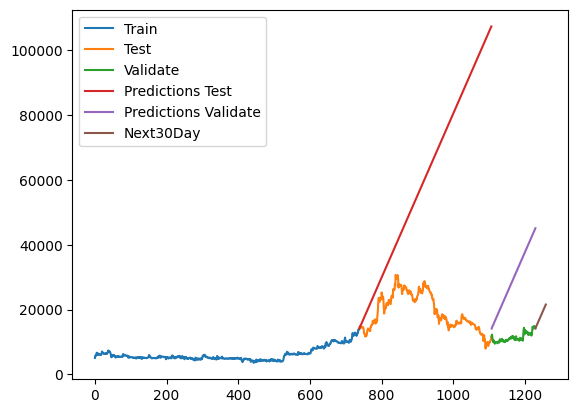

In [9]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=738, stop=1107, step=1)